In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import math
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

prices = pd.read_csv("prices.csv", index_col="Date", parse_dates=True)
volumechanges = pd.read_csv("volume.csv", index_col="Date", parse_dates=True).pct_change()*100

In [59]:
def getprice(date, ticker):
    global prices
    return prices.loc[date][ticker]


def transaction(id, ticker, amount, price, type, info):
    global transactionid
    if type == "buy":
        exp_date = today + dt.timedelta(days=7)
        transactionid += 1
    else:
        exp_date = today
    if type == "sell":
        data = {"id": id, "ticker": ticker, "amount": amount, "price": price, "date": today, "type": type,
                "exp_date": exp_date, "info": info}
    elif type == "buy":
        data = {"id": transactionid, "ticker": ticker, "amount": amount, "price": price, "date": today, "type": type,
                "exp_date": exp_date, "info": info}
        activelog.append(data)
    transactionlog.append(data)


def buy(interestlst, allocated_money):
    global money, portfolio
    for item in interestlst:
        price = getprice(today, item)
        if not np.isnan(price):
            quantity = math.floor(allocated_money/price)
            money -= quantity*price
            portfolio[item] += quantity
            transaction(0, item, quantity, price, "buy", "")


def sell():
    global money, portfolio, prices, today
    itemstoremove = []
    for i in range(len(activelog)):
        log = activelog[i]
        if log["exp_date"] <= today and log["type"] == "buy":
            tickprice = getprice(today, log["ticker"])
            if not np.isnan(tickprice):
                money += log["amount"]*tickprice
                portfolio[log["ticker"]] -= log["amount"]
                transaction(log["id"], log["ticker"], log["amount"], tickprice, "sell", log["info"])
                itemstoremove.append(i)
            else:
                log["exp_date"] += dt.timedelta(days=1)
    itemstoremove.reverse()
    for elem in itemstoremove:
        activelog.remove(activelog[elem])



def getindices():
    global tickers
    f = open("symbols.txt", "r")
    for line in f:
        tickers.append(line.strip())
    f.close()


def tradingday():
    global prices, today
    return np.datetime64(today) in list(prices.index.values)


def currentvalue():
    global money, portfolio, today, prices
    value = money
    for ticker in tickers:
        tickprice = getprice(today, ticker)
        if not np.isnan(tickprice):
            value += portfolio[ticker]*tickprice
    return int(value*100)/100


def main():
    global today
    getindices()
    for ticker in tickers:
        portfolio[ticker] = 0
    while today < simend:
        while not tradingday():
            today += dt.timedelta(days=1)
        simulation()
        currentpvalue = currentvalue()
        result.append(currentpvalue)
        today += dt.timedelta(days=7)
    plt.plot(result)

In [60]:
def simulation():
    global today, volumechanges, money
    start_date = today - dt.timedelta(days=14)
    series = volumechanges.loc[start_date:today].mean()
    interestlst = series[series > 15].index.tolist()
    sell()
    if len(interestlst) > 0:
        #moneyToAllocate = 500000/len(interestlst)
        #moneyToAllocate = currentvalue()/(2*len(interestlst))
        moneyToAllocate = money/(2*len(interestlst))
        buy(interestlst, moneyToAllocate)

In [61]:
result = []
today = dt.date(2018, 1, 1)
simend = dt.date(2020, 10, 8)
tickers = []
transactionid = 0
money = 1000000
portfolio = {}
activelog = []
transactionlog = []

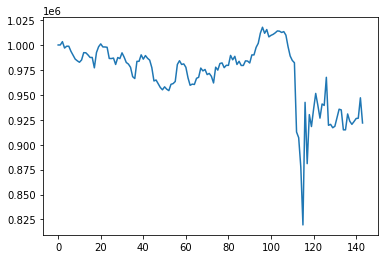

In [62]:
main()

In [64]:
transactionlog[-1]

{'id': 1571,
 'ticker': 'XRT',
 'amount': 1129,
 'price': 51.01,
 'date': datetime.date(2020, 10, 1),
 'type': 'buy',
 'exp_date': datetime.date(2020, 10, 8),
 'info': ''}